In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
TMinfo = pd.read_csv("./TMinfo",delimiter=',')
usages = pd.read_csv("./usages",delimiter=',')
wireshark = pd.read_csv("./wireshark",delimiter='\t',skiprows=0)
wireshark = wireshark.sort_values('timestamp').reset_index(drop=True)
wireshark = wireshark.filter(['timestamp','responseTime'], axis=1)
wireshark['responseTime'] = wireshark['responseTime'].apply(lambda x: x * 1000)

In [3]:
wireshark2 = pd.DataFrame(columns=['time','responseTime'])
wireshark2['time'] = wireshark2['time'].astype(np.int64)
wireshark2['responseTime'] = wireshark2['responseTime'].astype(float)

In [4]:
usages2 = pd.DataFrame(columns=['time','cpu_percent','phymem_percent','virtmem_percent','disk_percent'])
usages2['time'] = usages2['time'].astype(np.int64)
usages2['cpu_percent'] = usages2['cpu_percent'].astype(float)
usages2['phymem_percent'] = usages2['phymem_percent'].astype(float)
usages2['virtmem_percent'] = usages2['virtmem_percent'].astype(float)
usages2['disk_percent'] = usages2['disk_percent'].astype(float)

In [5]:
timestamps = pd.DataFrame(columns=['runID','start','techniqueStart','ransomwareStart','ransomwareStop','techniqueStop','stop'])
timestamps['runID'] = timestamps['runID'].astype(np.int64)
timestamps['start'] = timestamps['start'].astype(np.int64)
timestamps['techniqueStart'] = timestamps['techniqueStart'].astype(np.int64)
timestamps['ransomwareStart'] = timestamps['ransomwareStart'].astype(np.int64)
timestamps['ransomwareStop'] = timestamps['ransomwareStop'].astype(np.int64)
timestamps['techniqueStop'] = timestamps['techniqueStop'].astype(np.int64)
timestamps['stop'] = timestamps['stop'].astype(np.int64)

In [6]:
for runID in range(20):
    current_usages = usages.loc[usages['id']==runID]
    start_timestamp = current_usages.loc[current_usages['comment']=="START"].iloc[0].time
    technique_start_timestamp = current_usages.loc[current_usages['comment']=="TECHNIQUE_START"].iloc[0].time
    ransomware_start_timestamp = current_usages.loc[current_usages['comment']=="RANSOMWARE_START"].iloc[0].time
    ransomware_stop_timestamp = current_usages.loc[current_usages['comment']=="RANSOMWARE_STOP"].iloc[0].time
    technique_stop_timestamp = current_usages.loc[current_usages['comment']=="TECHNIQUE_STOP"].iloc[0].time
    stop_timestamp = current_usages.loc[current_usages['comment']=="STOP"].iloc[0].time
    timestamps.loc[len(timestamps)] = [runID,start_timestamp,technique_start_timestamp,ransomware_start_timestamp,ransomware_stop_timestamp,technique_stop_timestamp,stop_timestamp]
    current_usages["time"] = current_usages["time"].apply(lambda x: x - start_timestamp)
    current_wireshark = wireshark[(wireshark['timestamp'] >= start_timestamp) & (wireshark['timestamp'] <= stop_timestamp)]
    current_wireshark['timestamp'] = current_wireshark['timestamp'].apply(lambda x: x - start_timestamp)
    startTime = 0
    while startTime <= 600:
        endTime = startTime + 10
        tempWireshark = current_wireshark[(current_wireshark['timestamp'] >= startTime) & (current_wireshark['timestamp'] < endTime)]
        wireshark2.loc[len(wireshark2)] = [startTime, tempWireshark["responseTime"].mean()]
        tempUsages = current_usages[(current_usages['time'] >= startTime) & (current_usages['time'] < endTime)]
        usages2.loc[len(usages2)] = [startTime, tempUsages["cpu_percent"].mean(), tempUsages["phymem_percent"].mean(), tempUsages["virtmem_percent"].mean(), tempUsages["disk_percent"].mean()]
        startTime = endTime
timestamps.to_csv("./timestamps", index=False)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [7]:
ransomware_end_time = timestamps["ransomwareStop"] - timestamps["start"]
ransomware_end_time.mean()

282.05

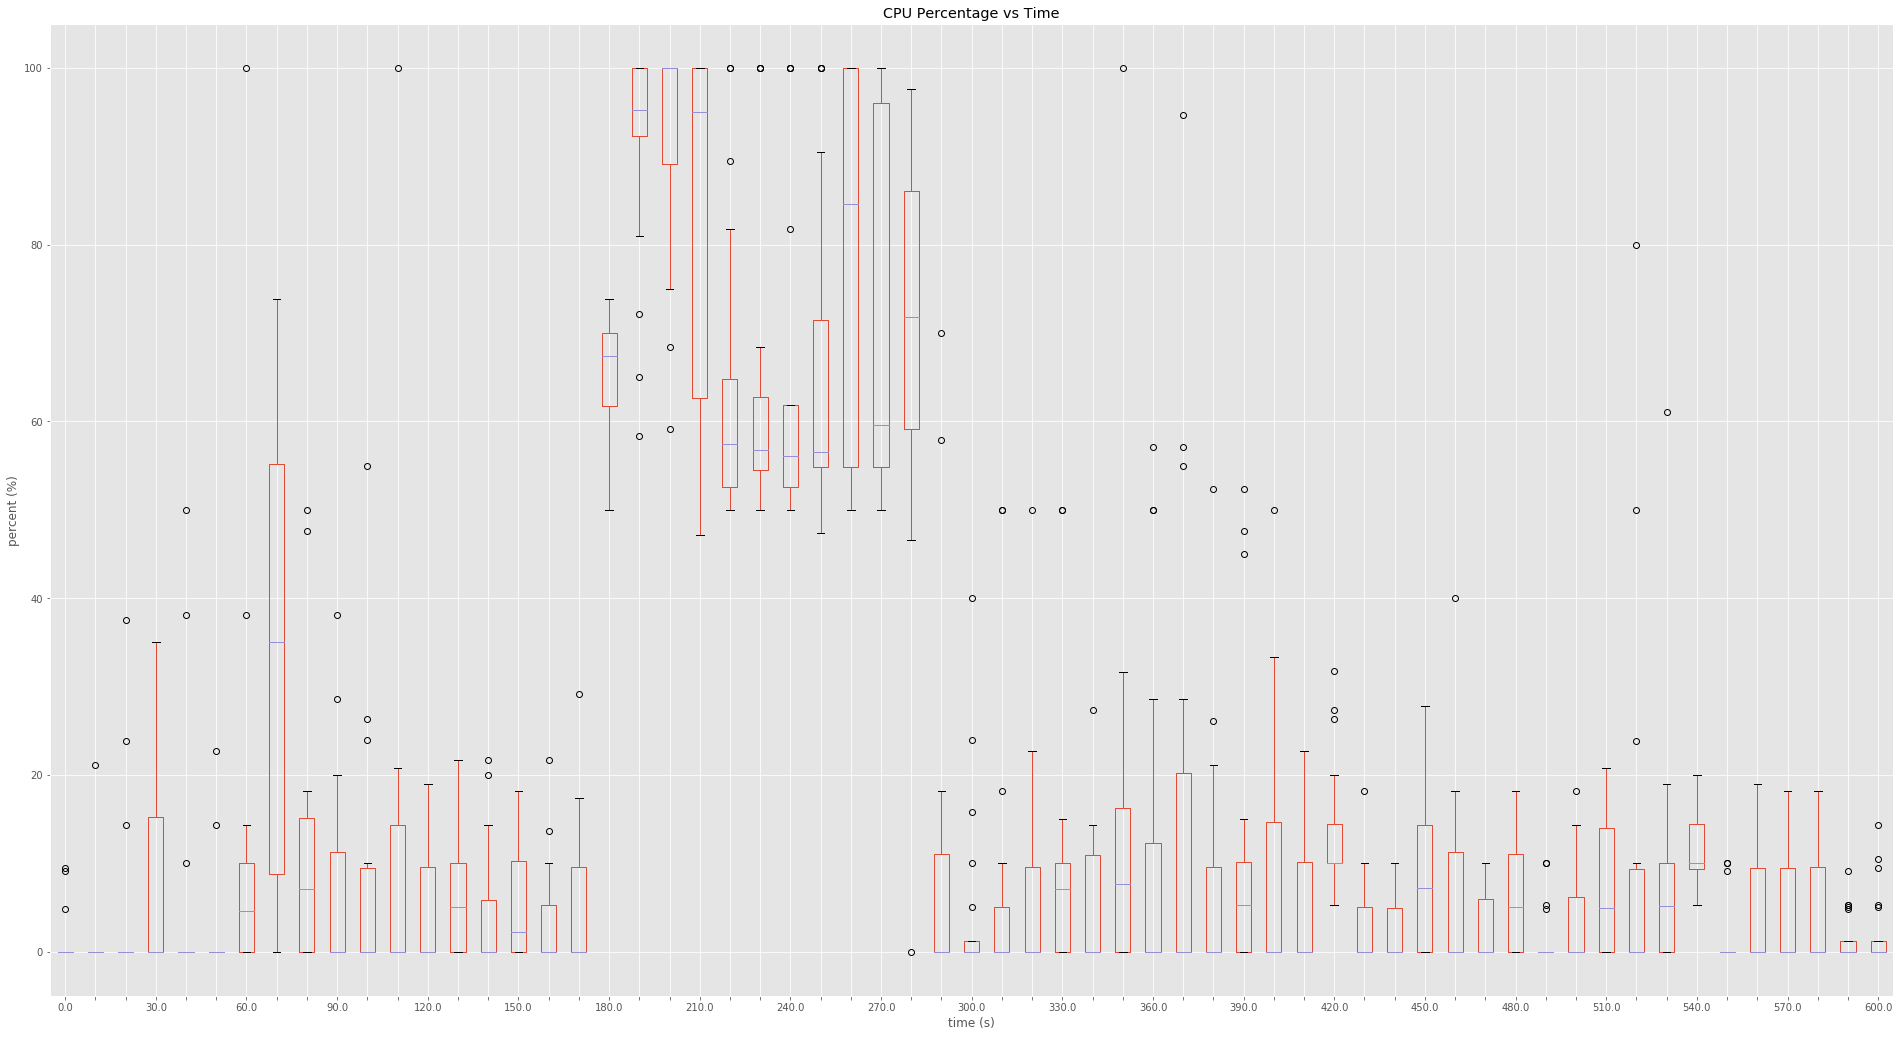

In [8]:
plt.style.use('ggplot')

newDF = usages2.filter(['time','cpu_percent'], axis=1)
newDF.boxplot(by='time', figsize=(32,18))
plt.title("CPU Percentage vs Time")
plt.xlabel("time (s)")
plt.ylabel("percent (%)")
plt.suptitle('')
locs, labels = plt.xticks()
for label in labels:
    if (int(float(label.get_text())) % 30 != 0):
        label.set_visible(False)
plt.savefig('cpu.png', dpi=100)

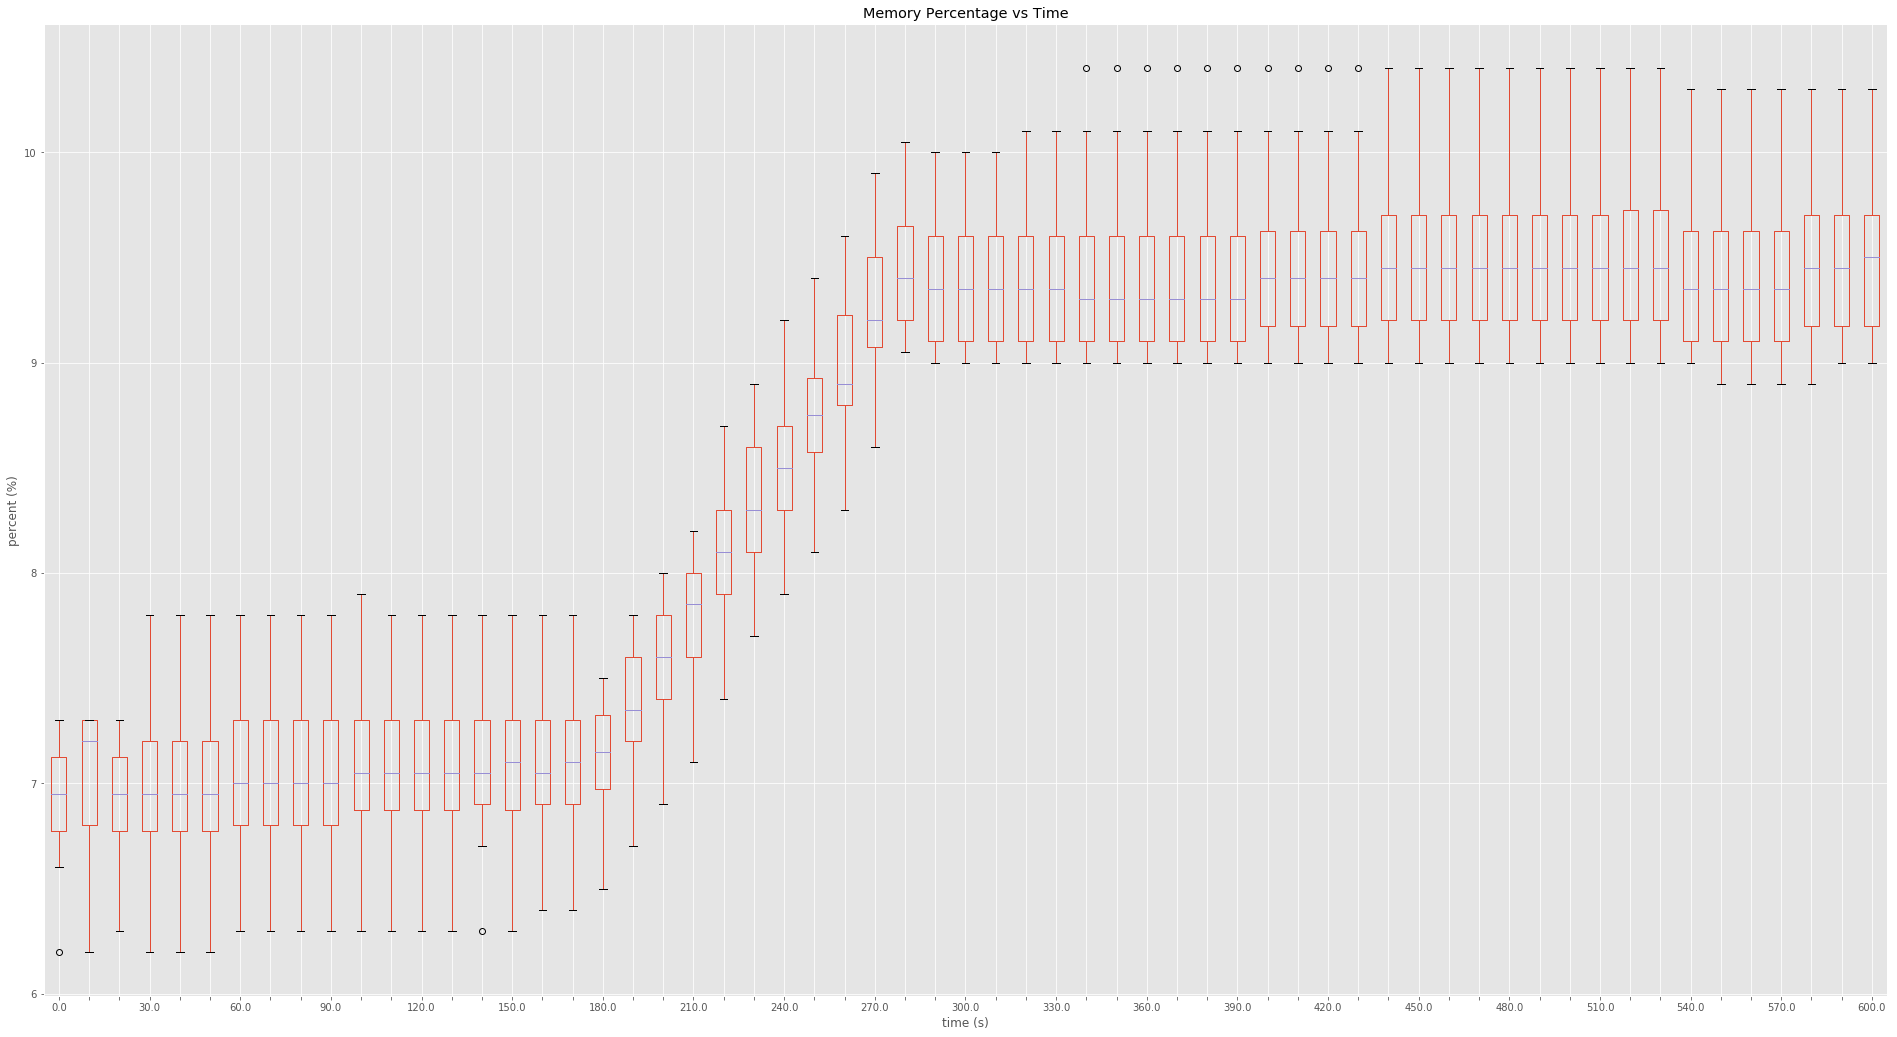

In [9]:
newDF = usages2.filter(['time','phymem_percent'], axis=1)
newDF.boxplot(by='time', figsize=(32,18))
plt.title("Memory Percentage vs Time")
plt.xlabel("time (s)")
plt.ylabel("percent (%)")
plt.suptitle('')
locs, labels = plt.xticks()
for label in labels:
    if (int(float(label.get_text())) % 30 != 0):
        label.set_visible(False)
plt.savefig('memory.png', dpi=100)

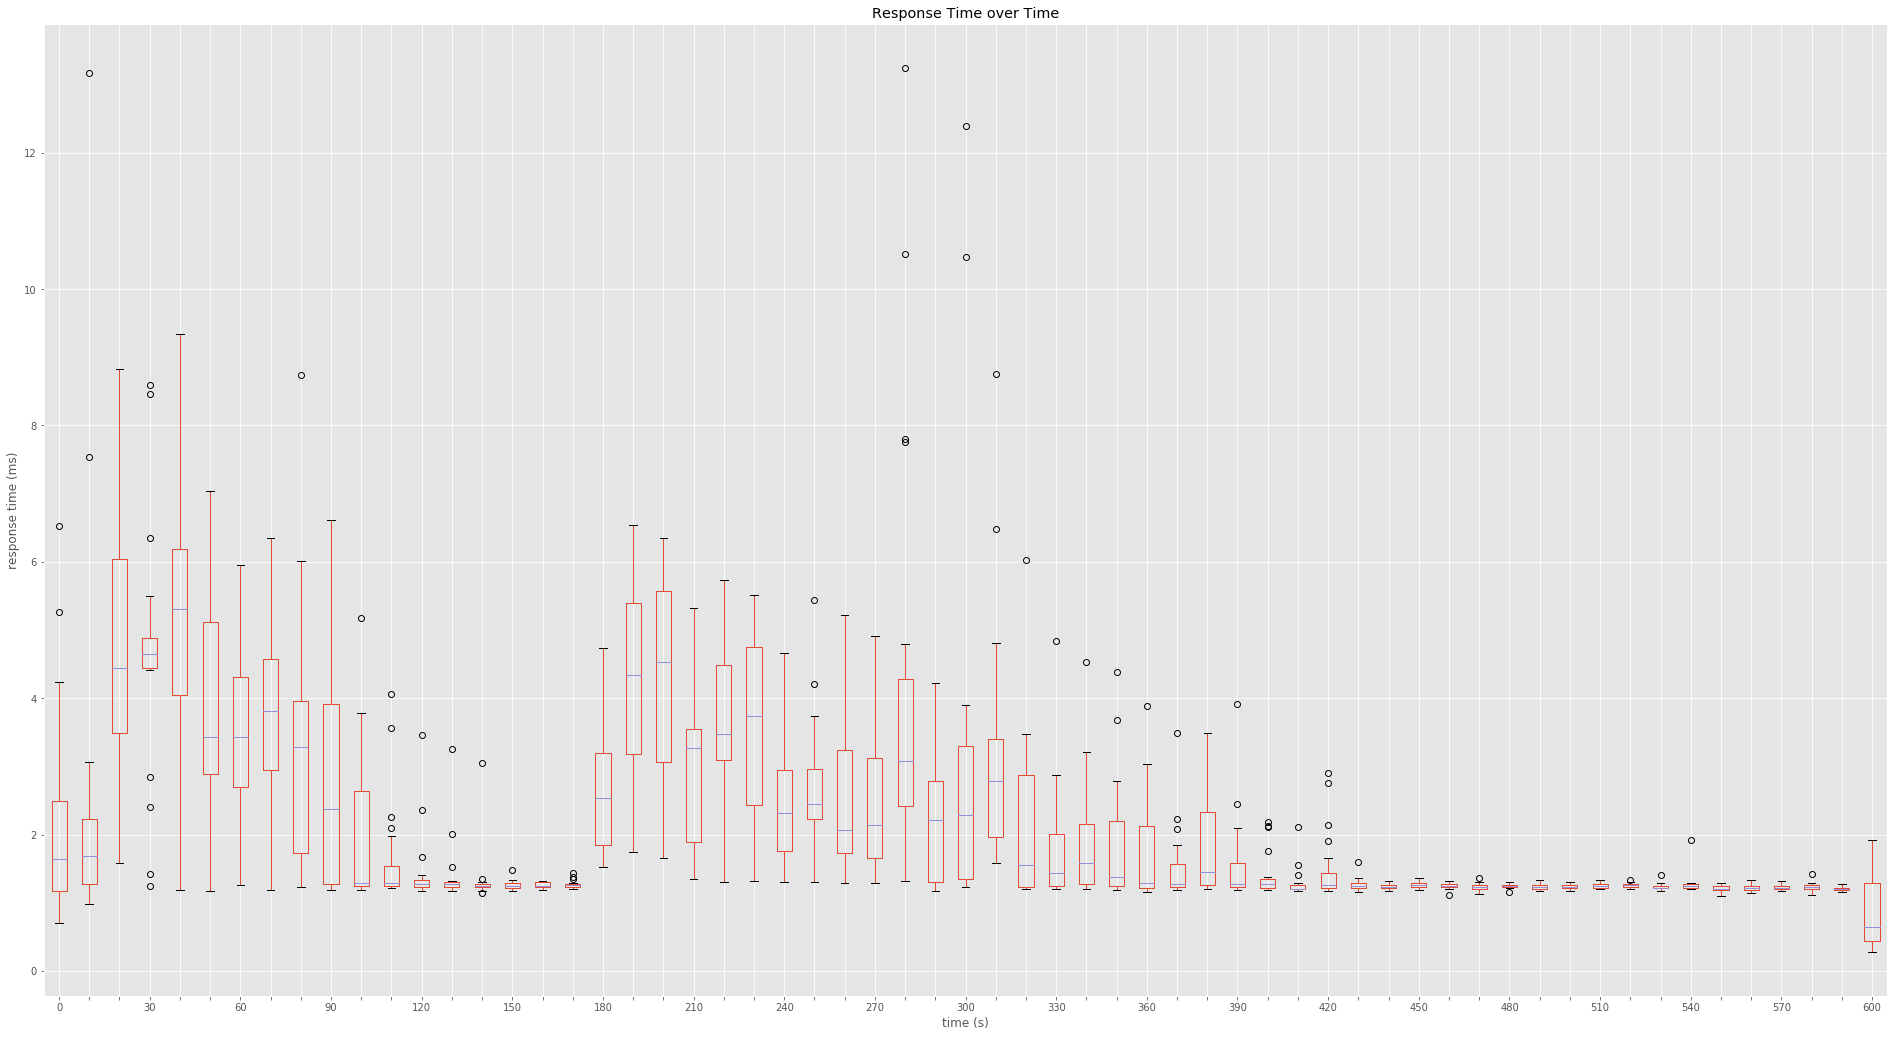

In [10]:
wireshark2['time'] = wireshark2['time'].astype(np.int64)
wireshark2.boxplot(by='time', figsize=(32,18))
plt.title("Response Time over Time")
plt.xlabel("time (s)")
plt.ylabel("response time (ms)")
plt.suptitle('')
locs, labels = plt.xticks()
for label in labels:
    if (int(label.get_text()) % 30 != 0):
        label.set_visible(False)
plt.savefig('responseTime.png', dpi=100)

In [11]:
print "Browsing"
newDF = usages2[(usages2['time'] >= 0) & (usages2['time'] < 60) | (usages2['time'] >= 540) & (usages2['time'] <= 600)]
server_cpu_mean = round(newDF['cpu_percent'].mean(),2)
server_cpu_std = round(newDF['cpu_percent'].std(),2)
print "CPU:- mean:" + str(server_cpu_mean) + " std:" + str(server_cpu_std)
server_phymem_mean = round(newDF['phymem_percent'].mean(),2)
server_phymem_std = round(newDF['phymem_percent'].std(),2)
print "Memory:- mean:" + str(server_phymem_mean) + " std:" + str(server_phymem_std)

Browsing
CPU:- mean:4.05 std:7.59
Memory:- mean:8.38 std:1.29


In [12]:
print "Browsing + RansomRescue"
newDF = usages2[(usages2['time'] >= 60) & (usages2['time'] < 180) | (usages2['time'] >= 282) & (usages2['time'] < 540)]
technique_cpu_mean = round(newDF['cpu_percent'].mean(),2)
technique_cpu_std = round(newDF['cpu_percent'].std(),2)
print "CPU:- mean:" + str(technique_cpu_mean) + " std:" + str(technique_cpu_std)
technique_phymem_mean = round(newDF['phymem_percent'].mean(),2)
technique_phymem_std = round(newDF['phymem_percent'].std(),2)
print "Memory:- mean:" + str(technique_phymem_mean) + " std:" + str(technique_phymem_std)

Browsing + RansomRescue
CPU:- mean:8.03 std:14.35
Memory:- mean:8.67 std:1.17


In [13]:
print "Browsing + RansomRescue + Ransomware"
newDF = usages2[(usages2['time'] >= 180) & (usages2['time'] < 282)]
rans_cpu_mean = round(newDF['cpu_percent'].mean(),2)
rans_cpu_std = round(newDF['cpu_percent'].std(),2)
print "CPU:- mean:" + str(rans_cpu_mean) + " std:" + str(rans_cpu_std)
rans_phymem_mean = round(newDF['phymem_percent'].mean(),2)
rans_phymem_std = round(newDF['phymem_percent'].std(),2)
print "Memory:- mean:" + str(rans_phymem_mean) + " std:" + str(rans_phymem_std)

Browsing + RansomRescue + Ransomware
CPU:- mean:73.43 std:20.02
Memory:- mean:8.29 std:0.79


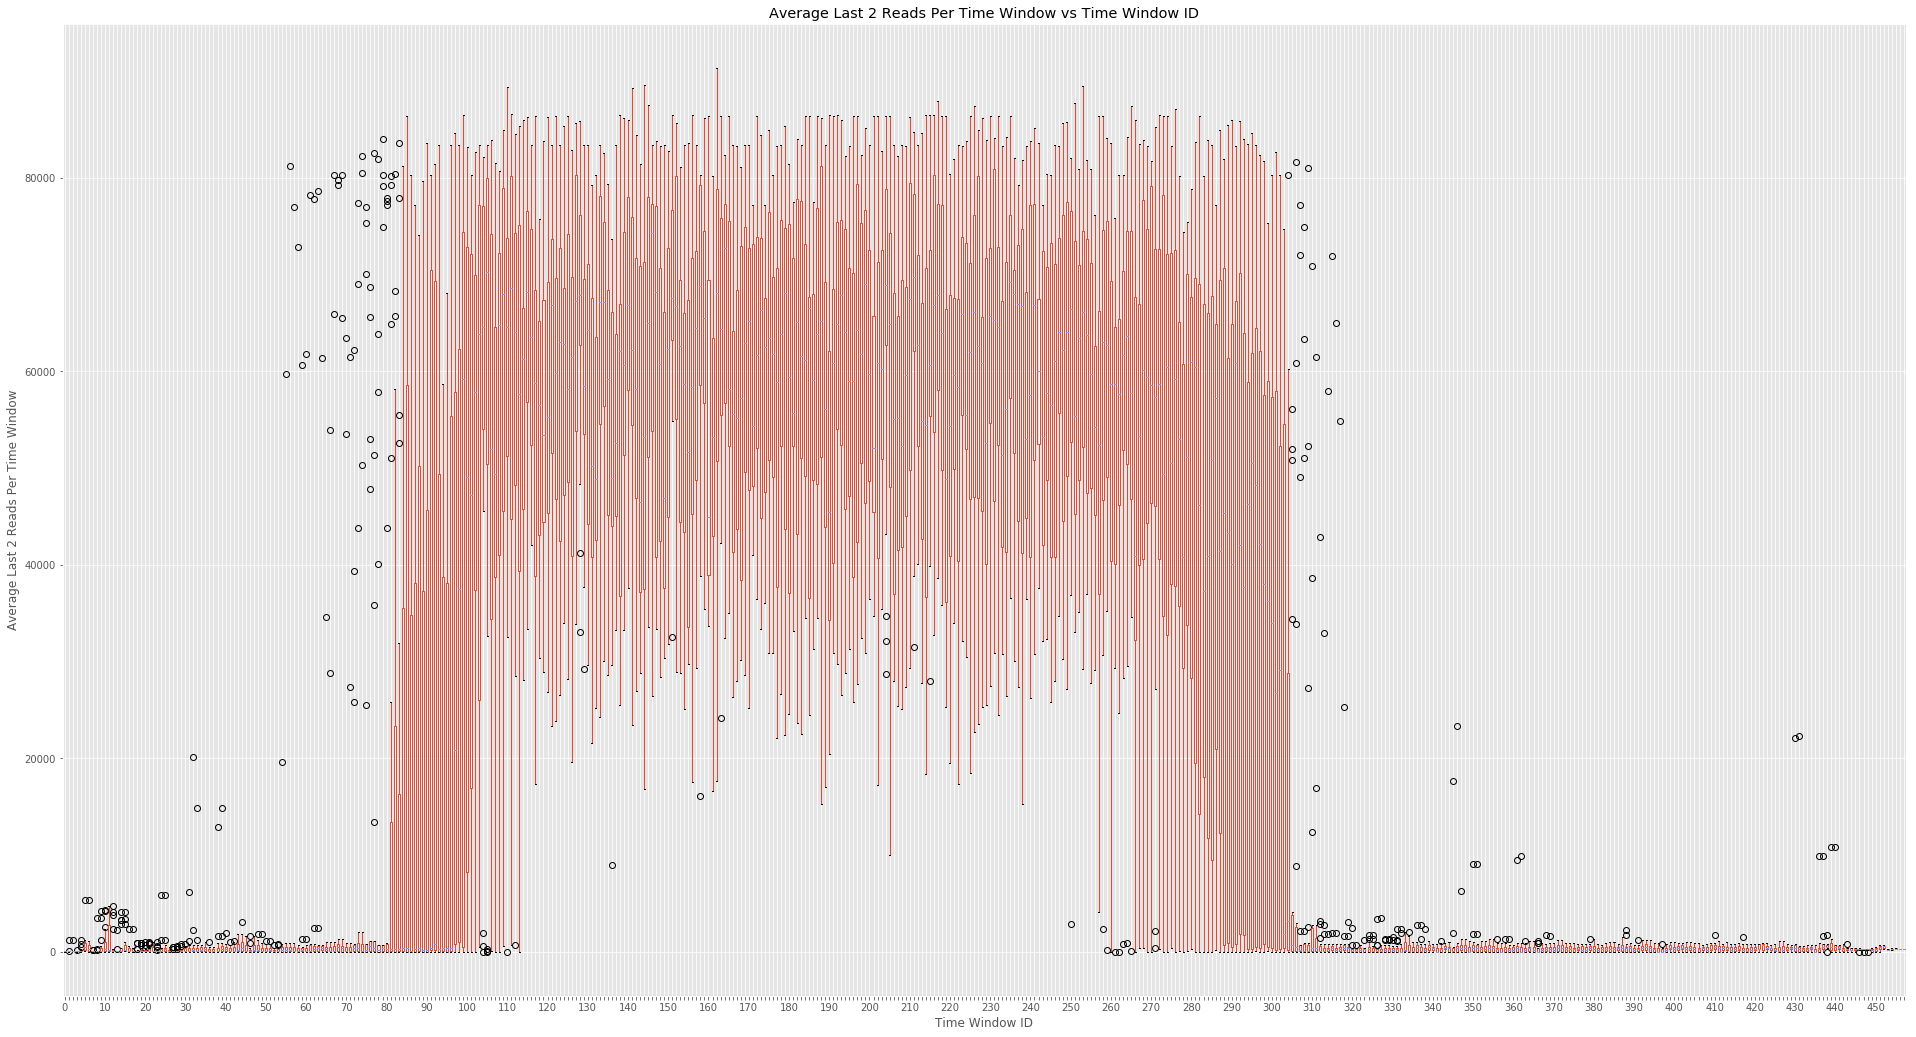

In [14]:
newDF = TMinfo.filter(['TimeWindowID','AverageLastNreadsPTW'], axis=1)
newDF.boxplot(by='TimeWindowID', figsize=(32,18))
plt.title("Average Last 2 Reads Per Time Window vs Time Window ID")
plt.xlabel("Time Window ID")
plt.ylabel("Average Last 2 Reads Per Time Window")
plt.suptitle('')
locs, labels = plt.xticks()
for label in labels:
    if (int(float(label.get_text())) % 10 != 0):
        label.set_visible(False)
plt.savefig('averageLast2readsPTW.png', dpi=200)

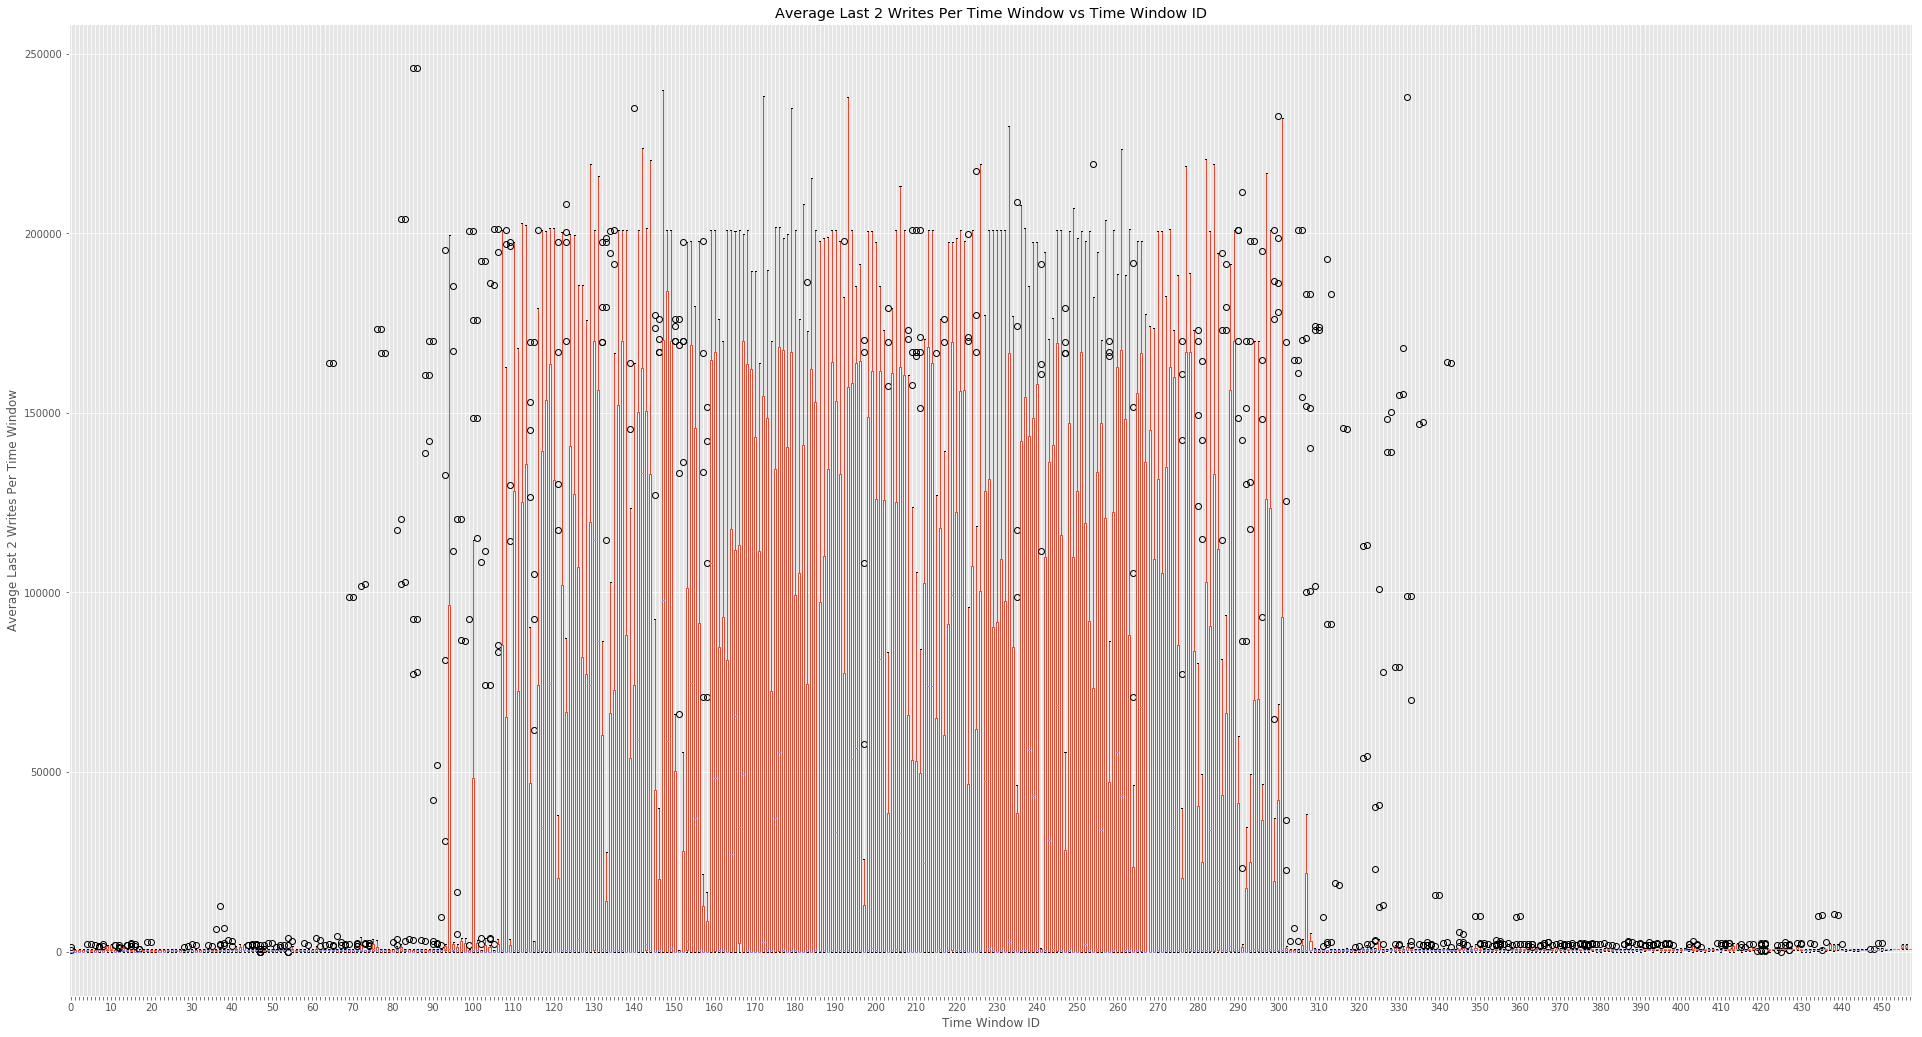

In [15]:
newDF = TMinfo.filter(['TimeWindowID','AverageLastNwritesPTW'], axis=1)
newDF.boxplot(by='TimeWindowID', figsize=(32,18))
plt.title("Average Last 2 Writes Per Time Window vs Time Window ID")
plt.xlabel("Time Window ID")
plt.ylabel("Average Last 2 Writes Per Time Window")
plt.suptitle('')
locs, labels = plt.xticks()
for label in labels:
    if (int(float(label.get_text())) % 10 != 0):
        label.set_visible(False)
plt.savefig('averageLast2writesPTW.png', dpi=200)